# GloFAS5: parameters
***

**Date**: 01-03-2025<br>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import yaml
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pickle

In [2]:
from lisfloodreservoirs import read_attributes#, read_timeseries
from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.utils.metrics import compute_performance

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## 1 Configuration

In [13]:
data_version = {
    'US': 'v2.0',
    'ES': 'v3.0',
    'MX': 'v1.0',
    'BR': 'v1.0',
}

reservoir_model = 'hanazaki_2pars'
run = 'bivariate'

data_dir = Path('/eos/jeodpp/home/users/casadje/data')
results_dir = Path('./results/all')
# results_dir.mkdir(parents=True, exist_ok=True)
glofas_dir = data_dir / 'GloFAS5' / 'reservoirs'
out_dir = glofas_dir / 'parameters'
plot_dir = out_dir / 'plots'
plot_dir.mkdir(parents=True, exist_ok=True)

paths_runs = {
    'default': data_dir / 'results' / reservoir_model / 'default',
    'storage': data_dir / 'results' / reservoir_model / 'calibration' / 'storage',
    'outflow': data_dir / 'results' / reservoir_model / 'calibration' / 'outflow',
    'bivariate': data_dir / 'results' / reservoir_model / 'calibration' / 'bivariate'
}

par_range ={
    'alpha': (0.2, 0.99),
    'beta': (0.001, 0.999), 
    'gamma': (0.001, 0.999),
    'delta': (0.1, 0.5),
    'epsilon': (0.001, 0.999),
}

metric = 'KGE'

parameter_names = {
    'alpha': 'flood_storage',
    'delta': 'outflow_factor'
}

## Data

### Reservoirs

In [55]:
# load reservoir table
res_dir = data_dir / 'GloFAS5' / 'reservoirs'
xls_file = list((res_dir).glob('*_reservoirs_*.xlsx'))[-1]
reservoirs = pd.concat([pd.read_excel(xls_file, sheet_name=sheet, index_col='GDW_ID') for sheet in ['as_reservoirs', 'as_lakes']], axis=0)

# convert to GeoPandas
reservoirs = gpd.GeoDataFrame(
    data=reservoirs,
    geometry=[Point(xy) for xy in zip(reservoirs.LisfloodX, reservoirs.LisfloodY)],
    crs='epsg:4326'
)

# map GRAND IDs and those use in LISFLOOD
map_grand_idx = {grand_id: idx for idx, grand_id in reservoirs.GRAND_ID.items() if not pd.isna(grand_id)}

reservoirs.shape

(1710, 27)

### Attributes

In [10]:
# load attributes
attributes = read_attributes(res_dir / 'attributes', reservoirs=reservoirs.index.tolist(), index_col='GDW_ID')
attributes.columns = attributes.columns.str.lower()

attributes.shape

(1710, 30)

### Reservoir parameters

In [67]:
# pars_calib = []
# for country, version in data_version.items():

#     # load optimal parameters
#     pars = pd.DataFrame(dtype=float)
#     path = data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / run
#     for file in path.glob('*samples.csv'):
#         # reservoir ID
#         grand_id = int(file.stem.split('_')[0])
#         if grand_id not in map_grand_idx:
#             continue
#         gdw_id = map_grand_idx[grand_id]
#         # extract best sample from the calibration
#         samples = pd.read_csv(file)
#         mask_cols = samples.columns.str.startswith('par')
#         parvalues = samples.loc[[samples.like1.idxmin()], mask_cols]
#         parvalues.index = [gdw_id]
#         parvalues.index.name = 'GDW_ID'
#         parvalues.rename(columns={col: col[3:] for col in parvalues.columns if col.startswith('par')}, inplace=True)
#         pars = pd.concat((pars, parvalues), axis=0)
#     pars.index.name = 'GDW_ID'
    
#     pars_calib.append(pars)

# pars_calib = pd.concat(pars_calib, axis=1).sort_index()

In [79]:
results = []
# default reservoir limits
limits_def = pd.DataFrame(dtype=float)
for country, version in data_version.items():
    
    paths_runs = {
        'default': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'default',
        'storage': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'storage',
        'outflow': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'outflow',
        'bivariate': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'bivariate'
    }

    runs = []
    for run, path in paths_runs.items():
        # optimal parameters
        parameters = pd.DataFrame(dtype=float)
        if run == 'default':
            for file in path.glob('*parameters.yml'):
                # reservoir ID
                ID = int(file.stem.split('_')[0])
                # extract alpha
                with open(file, 'r') as f:
                    lims = yaml.safe_load(f)
                limits_def = pd.concat((limits_def, pd.DataFrame({ID: lims}).transpose()), axis=0)
                parameters.loc[ID, 'alpha'] = lims['Vf'] / lims['Vtot']
                if reservoir_model.endswith('5pars'):
                    parameters.loc[ID, 'beta'] = (lims['Vtot'] - lims['Ve']) / (lims['Vtot'] - lims['Vf'])
                    parameters.loc[ID, 'gamma'] = lims['Vmin'] / lims['Vf'] 
                    parameters.loc[ID, 'epsilon'] = lims['Qn'] / lims['Qf']
            parameters['delta'] = 0.30
        else:
            for file in path.glob('*samples.csv'):
                # reservoir ID
                ID = int(file.stem.split('_')[0])
                # extract best sample from the calibration
                samples = pd.read_csv(file)
                mask_cols = samples.columns.str.startswith('par')
                parvalues = samples.loc[[samples.like1.idxmin()], mask_cols]
                parvalues.index = [ID]
                parvalues.index.name = 'ID'
                parvalues.rename(columns={col: col[3:] for col in parvalues.columns if col.startswith('par')}, inplace=True)
                parameters = pd.concat((parameters, parvalues), axis=0)
        parameters.index.name = 'ID'

        # performance
        performance = pd.DataFrame(dtype=float)
        for file in path.glob('*performance.csv'):
            # reservoir ID
            ID = int(file.stem.split('_')[0])
            # extract best sample from the calibration
            perf = pd.read_csv(file, index_col='metric')
            perf = perf.loc[[metric], ['storage', 'outflow']]
            perf.index = [ID]
            perf.index.name = 'ID'
            perf.columns = [f'{metric}_{col}' for col in perf.columns]
            performance = pd.concat((performance, perf), axis=0)

        # concat all results
        runs.append(xr.Dataset(pd.concat((parameters, performance), axis=1)).expand_dims(dim={'run': [run]}))

    # merge in a single Dataset
    runs = xr.merge(runs)
    runs = runs.reindex(run=['default', 'storage', 'outflow', 'bivariate'])
    results.append(runs)
results = xr.merge(results)

,alpha,delta
GDW_ID,,
20,0.216868,0.205800
21,0.986427,0.172560
26,0.505366,0.132248
27,0.203454,0.369380
28,0.200672,0.423646


### Model

In [82]:
# load model
with open(results_dir / 'random_forest_2' / 'random_forest_2par.pkl', 'rb') as file:
    model = pickle.load(file)

# feature names
features = model.feature_names_in_

## Reservoir parameters 

In [15]:
# # predict parameters
# parameters = pd.DataFrame(
#     index=reservoirs.index,
#     columns=parameter_names.keys()
# )

### Calibrated

In [50]:
# select the reservoirs that are included in GloFAS5 and rename the dimension
map_grand_idx = {grand_id: idx for idx, grand_id in reservoirs.GRAND_ID.items() if not pd.isna(grand_id) and grand_id in results.ID.data}
results = results.sel(ID=list(map_grand_idx))
results['ID'] = [map_grand_idx[grand_id] for grand_id in results.ID.data]
results = results.rename({'ID': 'GDW_ID'})

# extract the calibrated parameters as a DataFrame
pars_calib = pd.concat([results.sel(run=run)[par].to_pandas() for par in list(parameter_names)], axis=1)
pars_calib.columns = list(parameter_names)

pars_calib.head()

<xarray.Dataset>
Dimensions:      (GDW_ID: 51, run: 4)
Coordinates:
  * GDW_ID       (GDW_ID) int64 33 89 109 118 136 140 ... 6874 6932 7157 557 876
  * run          (run) <U9 'default' 'storage' 'outflow' 'bivariate'
Data variables:
    alpha        (run, GDW_ID) float64 0.7431 0.7301 0.7161 ... 0.4726 0.5639
    delta        (run, GDW_ID) float64 0.3 0.3 0.3 0.3 ... 0.499 0.1012 0.1016
    KGE_storage  (run, GDW_ID) float64 0.587 0.394 0.142 ... -0.216 0.6 0.644
    KGE_outflow  (run, GDW_ID) float64 0.656 0.804 -0.083 ... 0.809 0.444 0.182

### Estimated

In [92]:
# predict parameters
ids = reservoirs.index.difference(pars_calib.index)
pars_est = pd.DataFrame(
    data=model.predict(attributes.loc[ids, features]),
    index=ids,
    columns=parameter_names.keys()
)

### Combine

In [100]:
# combine and concat with reservoir table
parameters = pd.concat([pars_calib, pars_est], axis=0).sort_index()
reservoirs = pd.concat((reservoirs, parameters), axis=1)

#### Analyse

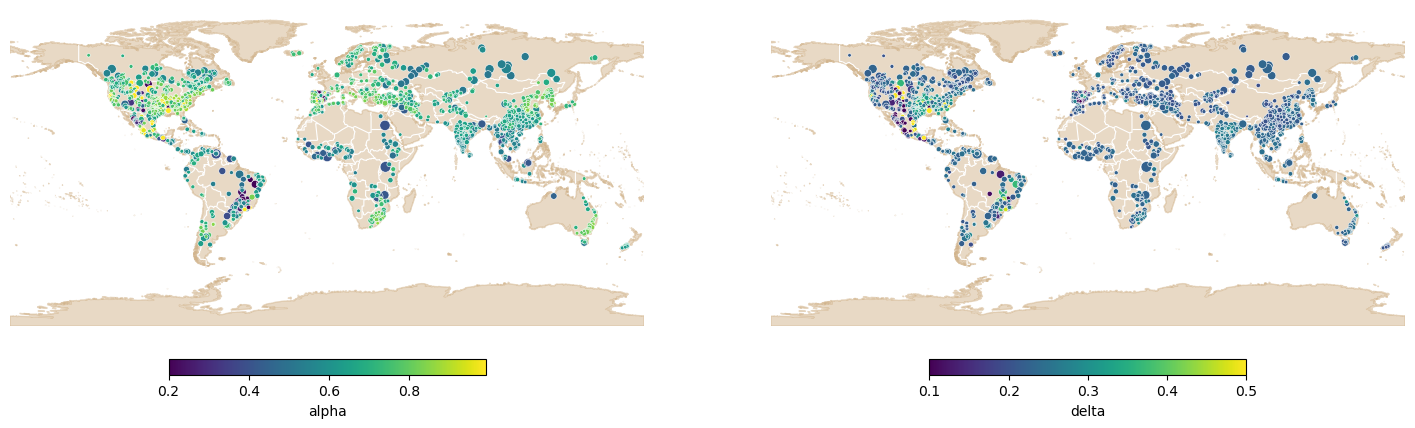

In [102]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8.5), subplot_kw=dict(projection=ccrs.PlateCarree()))
for ax, par in zip(axes, ['alpha', 'delta']):
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
    ax.add_feature(cfeature.BORDERS, edgecolor='w', linewidth=0.8, zorder=1)
    sct = ax.scatter(
        reservoirs.geometry.x,
        reservoirs.geometry.y,
        s=np.cbrt(reservoirs.CAP_MCM),
        c=reservoirs[par],
        edgecolor='w',
        lw=.4,
        cmap='viridis',
        norm=mcolors.Normalize(*par_range[par])
    )
    cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
    ax.set_extent([-180, 180, -90, 90])
    cbar.set_label(par)
    ax.axis('off');
plt.savefig(plot_dir / f'parameter_maps_GloFAS5.jpg', dpi=300, bbox_inches='tight')

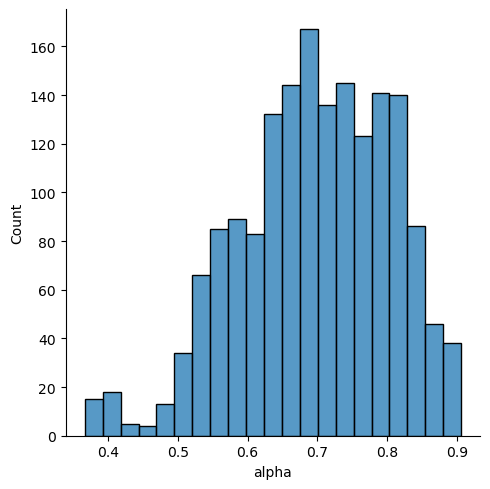

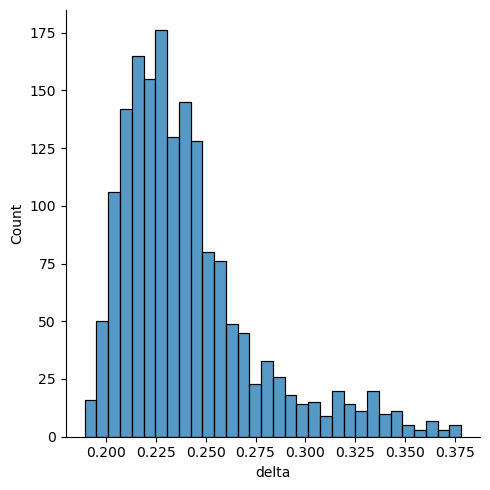

In [75]:
for par, name in parameter_names.items():
    sns.displot(reservoirs[par])
    plt.savefig(plot_dir / f'{name}.jpg', dpi=300, bbox_inches='tight')

In [104]:
# export
for par in parameters.columns:
    txt_file = out_dir / 'reservoirs_glofas5_{0}.txt'.format(parameter_names[par])
    parameters[par].to_csv(
        txt_file,
        sep='\t',
        header=None,
        float_format='%.6f'
    )
    print(f'Parameter {par} saved in file {txt_file}')

Parameter alpha saved in file /eos/jeodpp/home/users/casadje/data/GloFAS5/reservoirs/parameters/reservoirs_glofas5_flood_storage.txt
Parameter delta saved in file /eos/jeodpp/home/users/casadje/data/GloFAS5/reservoirs/parameters/reservoirs_glofas5_outflow_factor.txt
